# Quick Start Tutorial: End-to-End Workflow

## Learning Objectives

In this tutorial you will learn how to:
1. Create a catalog
2. Define a data model for a catalog
3. Add features to a catalog
4. Solve a use case
5. Deploy and serve a feature list
6. Manage the feature list lifecycle

## Set up the prerequisites

Learning Objectives

In this section you will:
* import libraries
* start your local featurebyte server

### Load the featurebyte library and connect to the local instance of featurebyte

In [1]:
# library imports
import pandas as pd
import numpy as np
from datetime import datetime

# load the featurebyte SDK
import featurebyte as fb

# start the local server, then wait for it to be healthy before proceeding
fb.playground()

02:09:43 | INFO     | Using configuration file at: /home/chester/.featurebyte/config.yaml
02:09:43 | INFO     | Active profile: local (http://127.0.0.1:8088)
02:09:43 | INFO     | SDK version: 0.2.2
02:09:43 | INFO     | Active catalog: default
02:09:43 | INFO     | 0 feature list, 0 feature deployed
02:09:43 | INFO     | (1/4) Starting featurebyte services
 Container mongo-rs  Running
 Container featurebyte-server  Running
 Container spark-thrift  Running
 Container redis  Running
 Container featurebyte-worker  Running
 Container mongo-rs  Waiting
 Container mongo-rs  Waiting
 Container redis  Waiting
 Container redis  Healthy
 Container mongo-rs  Healthy
 Container mongo-rs  Healthy
02:09:44 | INFO     | (2/4) Creating local spark feature store
02:09:44 | INFO     | (3/4) Import datasets
02:09:45 | INFO     | Dataset grocery already exists, skipping import
02:09:45 | INFO     | Dataset healthcare already exists, skipping import
02:09:45 | INFO     | Dataset creditcard already exists,

## Create a catalog

Once you have a feature store, you can create a Catalog, which acts as a central repository for metadata related to FeatureByte objects: tables, entities, features, and feature lists.

For data sources covering multiple domains, use separate Catalogs for each domain to maintain clarity and easy access to domain-specific metadata.

Learning Objectives

In this section you will:
* learn about catalogs
* create a new catalog

### Concept: Catalog

A Catalog object operates as a centralized metadata repository for organizing tables, entities, features, and feature lists and other objects to facilitate feature serving for a specific domain.
By employing a catalog, your team members can share, search, access, and reuse these assets.

### Example: Create a new catalog

In [2]:
catalog_name = "quick start end-to-end " + datetime.now().strftime("%Y%m%d:%H%M")

# create a catalog
catalog = fb.Catalog.create(catalog_name, "playground")

In [3]:
# you can activate an existing catalog
catalog = fb.Catalog.activate(catalog_name)

02:09:45 | INFO     | Catalog activated: quick start end-to-end 20230511:0209


## Define a Data Model

Defining your Catalog's Data Model is crucial for facilitating feature engineering, organization, and serving of features and feature lists. It is an infrequent but essential task to ensure good practices. 

Learning Objectives

In this section you will:
* be introduced to the case study dataset
* declare FeatureByte catalog tables
* define data cleaning operations
* declare and tag entities

### Case Study: French grocery dataset

The French grocery dataset contains four tables containing data from a chain of grocery stores.

The data source has already been declared in the playground feature store that was installed as part of FeatureByte.

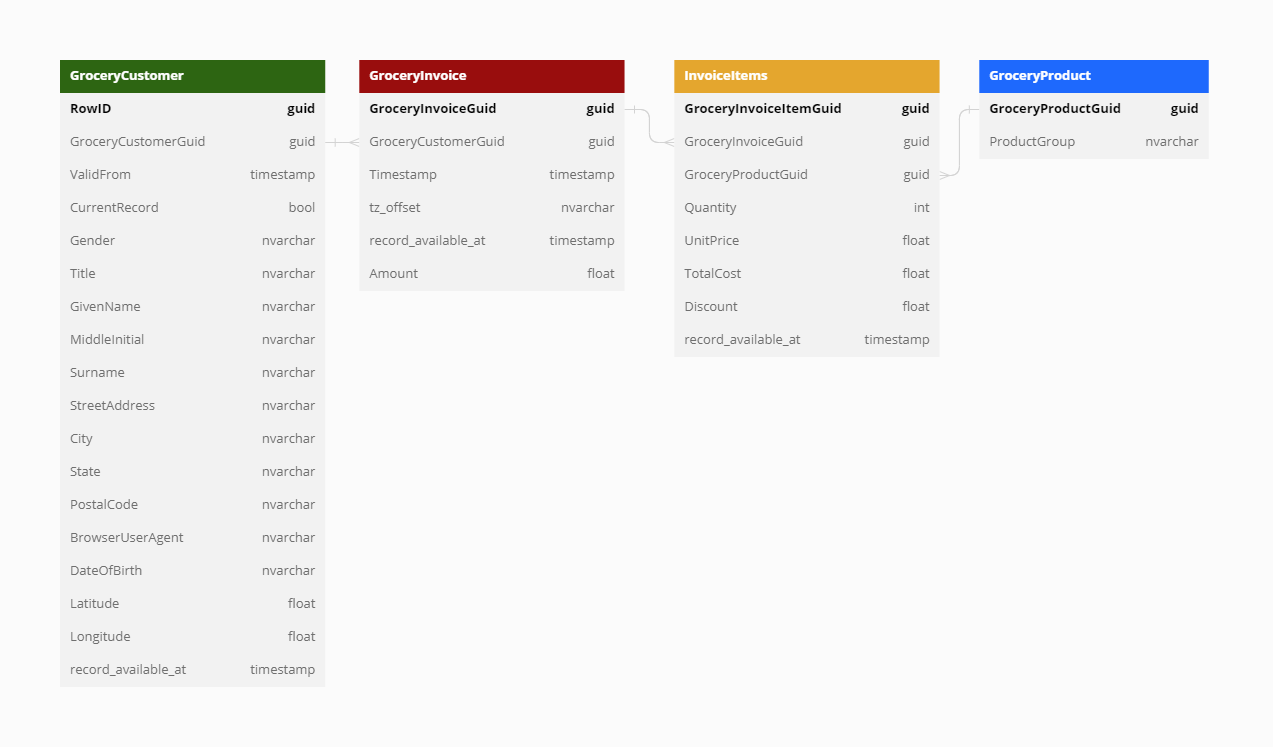

### Concept: Data source

A data source is a collection of tables accessible via a connection to a data warehouse or database. It is used to explore and retrieve details about tables that can be used as source table in the FeatureByte catalog. 

### Example: Connect to a pre-defined data source

In [4]:
# get data source from the local spark feature store
ds = fb.FeatureStore.get("playground").get_data_source()

### Concept: Catalog table

A Catalog Table provides a centralized location for metadata about a source table. This metadata determines the type of operations that can be applied to the table's views and includes essential information for feature engineering.

### Example: Declare catalog tables

In [5]:
# register GroceryInvoice as an event data
invoice_table = ds.get_source_table(
    database_name="spark_catalog", schema_name="GROCERY", table_name="GROCERYINVOICE"
).create_event_table(
    name="GROCERYINVOICE",
    event_id_column="GroceryInvoiceGuid",
    event_timestamp_column="Timestamp",
    event_timestamp_timezone_offset_column="tz_offset",
    record_creation_timestamp_column="record_available_at",
)

# show sample data
invoice_table.sample(5)

,GroceryInvoiceGuid,GroceryCustomerGuid,Timestamp,tz_offset,record_available_at,Amount
0,6f0f8768-59b0-4bf1-aa21-258c83515e45,d2fc87d2-3584-4c8f-9359-b3ff10b5dc09,2022-12-26 16:29:21,+01:00,2022-12-26 17:01:00,24.04
1,7d12246f-d5f7-4ed6-8aa2-8611beb7f613,b6d4377e-9f04-4c04-bc56-b970e54279ca,2023-02-18 16:00:03,+01:00,2023-02-18 17:01:00,25.61
2,49887643-3fa1-4171-89e0-344160238c01,c22fa3eb-55a5-4a4f-9301-38f6b6f0567e,2022-06-23 18:24:52,+02:00,2022-06-23 19:01:00,23.88
3,2cfae7b0-b3a2-4973-9561-de8e4788e388,e034e01c-50de-42f0-a879-82c093af5f49,2022-12-19 15:49:29,+01:00,2022-12-19 16:01:00,6.21
4,360eb328-b0cb-4f75-bf64-d6b5216b50ad,7a1bc5dc-e198-419e-b972-0abbdf8903c1,2022-02-13 16:52:33,+01:00,2022-02-13 17:01:00,14.30


In [6]:
# register invoice items as an item table
items_table = ds.get_source_table(
    database_name="spark_catalog", schema_name="GROCERY", table_name="INVOICEITEMS"
).create_item_table(
    name="INVOICEITEMS",
    event_id_column="GroceryInvoiceGuid",
    item_id_column="GroceryInvoiceItemGuid",
    event_table_name="GROCERYINVOICE",
)

# show sample data
items_table.sample(5)

,GroceryInvoiceItemGuid,GroceryInvoiceGuid,GroceryProductGuid,Quantity,UnitPrice,TotalCost,Discount,record_available_at
0,0c5181e3-9d9c-402d-902a-1649c3a26232,8d99deb7-78cc-4924-ac04-9cb99e1e282c,8b9739d4-1a3f-4c96-886d-d0492ba45c07,1.0,1.74,1.74,0.18,2022-08-02 10:01:00
1,5b853ed2-aea7-4fad-aaa5-bcadbef0eba8,163e7004-db43-4e0d-a093-cd7bf27caf10,a7fd9147-874f-4f3d-b262-3e408cc30db8,1.0,2.50,2.50,0.39,2023-04-14 17:01:00
2,d2d7633e-3bdf-430d-920e-13825cad3e19,4aac4b3b-0cd9-4bf7-a650-68f40fb85865,5d9e7f80-4c03-44b9-b44b-5083f0645261,1.0,0.75,0.75,0.00,2022-06-28 13:01:00
3,7c4c38cc-7150-4bca-b2c1-0d4616d4809f,5226254f-97d6-4080-a4fa-0269f2da1bc0,a59f0ed9-f70d-474d-9347-4605af059856,3.0,0.66,1.98,0.00,2022-02-24 13:01:00
4,cd0d8e88-e8fd-41d9-a4a4-8c9d4e05a1d8,af5633bc-0008-40ee-b1a1-8dfd4c98eba9,5f38510e-1c5f-481a-98e8-8c282b03e7bf,1.0,1.29,1.29,0.00,2022-03-20 14:01:00


### Concept: Feature job setting

The Feature Job Setting in FeatureByte captures essential details about batch feature computations for the online feature store, including the frequency and timing of the batch process, as well as the assumed blind spot for the data. This helps to maintain consistency between offline and online feature values and ensures accurate historical serving that reflects the production environment. The setting comprises three parameters:

* The frequency parameter specifies how often the batch process should run.
* The time_modulo_frequency parameter defines the timing of the batch process.
* The blind_spot parameter sets the time gap between feature computation and the latest event timestamp to be processed.

To ensure consistency of Feature Job Setting across features created by different team members, a Default Feature Job Setting is defined at the table level. However, it's possible to override this setting during feature declaration.

### Example: Feature job settings analysis

In [7]:
# initialize the feature job settings for the invoice table
invoice_table.initialize_default_feature_job_setting()

Done! |████████████████████████████████████████| 100% in 12.1s (0.08%/s)        


### Concept: Cleaning operations

Cleaning Operations determine the procedure for cleaning data in a table column before performing feature engineering. The cleaning operations can either be set as a default operation in the metadata of a table column or established when creating a view in a manual mode.

These operations specify how to manage the following scenarios:
* Missing values
* Disguised values
* Values that are not in an anticipated list
* Numeric values and dates that are out of boundaries
* String values when numeric values are expected

For a specific column, define an ordered sequence of cleaning operations. Ensure that values imputed in earlier steps are not marked for cleaning in later operations.

### Example: Correct negative discounts and missing discount amounts

In [8]:
# discount amount cannot be negative
items_table.Discount.update_critical_data_info(
    cleaning_operations=[
        fb.MissingValueImputation(imputed_value=0),
        fb.ValueBeyondEndpointImputation(type="less_than", end_point=0, imputed_value=0),
    ]
)

### Concept: Entity

An Entity object contains metadata on a real-world object or concept represented or referenced by tables within your data warehouse.

Entities facilitate automatic table join definitions, serve as the unit of analysis for feature engineering, and aid in organizing features, feature lists, and use cases.

All features must relate to an entity (or entities) as their primary unit of analysis.

### Example: Declare new entities

In [9]:
# register new entities
entity1 = catalog.create_entity(name="grocerycustomer", serving_names=["GROCERYCUSTOMERGUID"])
entity2 = catalog.create_entity(name="groceryinvoice", serving_names=["GROCERYINVOICEGUID"])

### Concept: Entity Tagging

The Entity Tagging process involves identifying the specific columns in tables that identify or reference a particular entity. These columns are often primary keys, natural keys, or foreign keys. This process is a critical step in preparing data before feature engineering, all features must relate to an entity (or entities) as their primary unit of analysis.

### Example: Entity tagging

In [10]:
# tag the entities for the grocery invoice table
invoice_table.GroceryInvoiceGuid.as_entity("groceryinvoice")
invoice_table.GroceryCustomerGuid.as_entity("grocerycustomer")

# tag the entities for the grocery items table
items_table.GroceryInvoiceGuid.as_entity("groceryinvoice")

## Add Features to a Catalog

Learning Objectives

In this section you will:
* learn the purpose of views
* create views from tables
* transform data in a view
* filter rows in a view

### Concept: FeatureByte Views

A view is a local virtual table that can be modified and joined to other views to prepare data before feature definition. A view does not contain any data of its own.

Views in FeatureByte allow operations similar to Pandas, such as:

- creating and transforming columns and extracting lags
- filtering records, capturing attribute changes, and joining views

Unlike Pandas DataFrames, which require loading all data into memory, views are materialized only when needed during previews or feature materialization.

When a view is created, it inherits the metadata of the catalog table it originated from. Currently, five types of views are supported:

- Event Views created from an Event table
- Item Views created from an Item table
- Dimension Views created from a Dimension table
- Slowly Changing Dimension (SCD) Views created from a SCD table
- Change Views created from a [SCD table](#slowly-changing-dimension-scd-table).

Two view construction modes are available:
* Auto (default): Automatically cleans data according to default operations specified for each column within the table and excludes special columns not meant for feature engineering.
* Manual: Allows custom cleaning operations without applying default cleaning operations.

Although views provide access to cleaned data, you can still perform data manipulation using the raw data from the source table. To do this, utilize the view's raw attribute, which enables you to work directly with the unprocessed data of the source table.


### Example: Create views from tables

In [11]:
# get the view objects
items_view = items_table.get_view()
invoice_view = invoice_table.get_view()

### Concept: Feature

A Feature object contains the logical plan to compute a feature which is usually used as input data to train or predict Machine Learning models.

There are three ways to define the plan for Feature objects from views: either as a Lookup feature, as an Aggregate feature or as a Cross Aggregate feature.

Additionally, Feature objects can be created as transformations of one or more existing features.

### Concept: Observation set

An observation set combines entity key values and historical points-in-time, for which you wish to materialize feature values.

The observation set can be a pandas DataFrame or an ObservationTable object representing an observation set in the feature store.

### Example: Creating an observation set

In [12]:
# get some invoice IDs and invoice event timestamps from 2022
filter = (invoice_view["Timestamp"].dt.year == 2022) & (invoice_view["Timestamp"].dt.month >= 10)
observation_set = (
    invoice_view[filter]
    .sample(5)[["GroceryCustomerGuid", "Timestamp"]]
    .rename(
        {
            "Timestamp": "POINT_IN_TIME",
            "GroceryCustomerGuid": "GROCERYCUSTOMERGUID",
        },
        axis=1,
    )
)
display(observation_set)

,GROCERYCUSTOMERGUID,POINT_IN_TIME
0,7a1bc5dc-e198-419e-b972-0abbdf8903c1,2022-12-23 10:41:08
1,6999ea3f-fc7e-4b48-b01f-02a71e0f474d,2022-11-30 18:25:02
2,33a71f26-f36f-423f-8ddb-a7d674102d3b,2022-10-29 09:29:31
3,adb23858-0ea8-4ec1-9d17-5ae5cb70d856,2022-11-29 11:54:38
4,09fbee0c-521e-40ee-a2ff-8ed4187dcbc4,2022-11-09 16:57:02


### Concept: Aggregate feature

Aggregate Features are an important type of feature engineering that involves applying various aggregation functions to a collection of data points grouped by an entity (or a tuple of entities). Supported aggregation functions include the latest, count, sum, average, minimum, maximum, and standard deviation. It is important to consider the temporal aspect when conducting these aggregation operations.

There are three main types of aggregate features, including simple aggregates, aggregates over a window, and aggregates "as at" a point-in-time.

If a feature is intended to capture patterns of interaction between two or more entities, these aggregations are grouped by the tuple of the entities. For instance, an aggregate feature can be created to show the amount spent by a customer with a merchant in the recent past.

### Concept: Aggregates over a window

Aggregates over a window refer to features that are generated by aggregating data within a specific time frame. These types of features are commonly used for analyzing event and item data.

### Example: Syntax for creating an aggregate feature over a window

In [13]:
# get the discount on a grocery item for each customer over 90 days and 180 days, grouped by customer
customer_max_discount = items_view.groupby("GroceryCustomerGuid").aggregate_over(
    "Discount",
    method=fb.AggFunc.MAX,
    feature_names=["CustomerMaxDiscount_30days", "CustomerMaxDiscount_90days"],
    fill_value=0,
    windows=["30d", "90d"],
)
customer_max_discount.save()

# create a multi-row preview of the feature values
display(customer_max_discount.preview(observation_set))

,GROCERYCUSTOMERGUID,POINT_IN_TIME,CustomerMaxDiscount_30days,CustomerMaxDiscount_90days
0,7a1bc5dc-e198-419e-b972-0abbdf8903c1,2022-12-23 10:41:08,3.89,3.89
1,6999ea3f-fc7e-4b48-b01f-02a71e0f474d,2022-11-30 18:25:02,0.89,3.00
2,33a71f26-f36f-423f-8ddb-a7d674102d3b,2022-10-29 09:29:31,2.58,2.58
3,adb23858-0ea8-4ec1-9d17-5ae5cb70d856,2022-11-29 11:54:38,0.00,0.00
4,09fbee0c-521e-40ee-a2ff-8ed4187dcbc4,2022-11-09 16:57:02,2.56,4.80


In [14]:
# get the total amount of invoices for each customer over the past 14 days
customer_invoice_total_14d = items_view.groupby("GroceryCustomerGuid").aggregate_over(
    "Discount",
    method=fb.AggFunc.SUM,
    feature_names=["CustomerInvoiceTotal_14days"],
    fill_value=0,
    windows=["14d"],
)
customer_invoice_total_14d.save()

## Solve a Use Case

Learning Objectives

In this section you will learn how to:
* design an observation set for training data
* create a feature list
* create historical training data
* consume training data to train a machine learning model

### Case Study: Predicting Customer Spend

Your chain of grocery stores wants to target market customers immediately after each purchase. As one step in this marketing campaign, they want to predict future customer spend in the 14 days after a purchase.

### Example: Create an observation set for training data

In [15]:
# filter to get the second half of 2022
filter = (invoice_view["Timestamp"].dt.year == 2022) & (invoice_view["Timestamp"].dt.month >= 2)

# create a pandas data frame a sample of the customer IDs and timestamps
observation_set_features = observation_set = (
    invoice_view[filter]
    .sample(1000)[["GroceryCustomerGuid", "Timestamp"]]
    .rename(
        {
            "Timestamp": "POINT_IN_TIME",
            "GroceryCustomerGuid": "GROCERYCUSTOMERGUID",
        },
        axis=1,
    )
)
display(observation_set_features)

,GROCERYCUSTOMERGUID,POINT_IN_TIME
0,489b3454-bd45-4d14-a355-500f42bad6c2,2022-02-18 18:23:39
1,36f0d7a8-f3ca-409d-9f78-c30da3591520,2022-08-20 13:43:49
2,43f100f0-f804-4774-a8a5-dee3ad2f9ea5,2022-12-06 16:36:38
3,a80fe37e-4b4b-4973-b076-35b302dba24b,2022-04-02 11:11:38
4,c9bdbb70-27e7-4ca1-a429-17b67703c06b,2022-03-20 19:20:30
...,...,...
995,9a0fa7c1-f136-43e1-8618-d49947d150cc,2022-10-05 14:19:32
996,b6cb759f-20d0-4a1f-902c-f62881bda7e6,2022-07-31 16:34:05
997,402d0c33-adfa-4bdd-a4be-fce76171466d,2022-12-26 20:55:59
998,12ba5d8e-736c-4ffa-b56c-a9667ea115f0,2022-08-19 08:26:47


### Concept: Feature list

A FeatureList object is a collection of Feature objects that is tailored to meet the needs of a particular use case. It is commonly used in generating feature values for Machine Learning training and inference.

### Example: Create a feature list

In [16]:
# create a feature list
feature_list = fb.FeatureList(
    [customer_max_discount, customer_invoice_total_14d], name="customer features"
)
feature_list.save()

Saving Feature(s) |████████████████████████████████████████| 3/3 [100%] in 1.5s 
Loading Feature(s) |████████████████████████████████████████| 3/3 [100%] in 2.6s


In [17]:
# create a feature list for the target
target_list = fb.FeatureList([customer_invoice_total_14d], name="Target feature")
target_list.save()

Saving Feature(s) |████████████████████████████████████████| 1/1 [100%] in 0.5s 
Loading Feature(s) |████████████████████████████████████████| 1/1 [100%] in 0.5s


### Concept: Materialization

A feature in FeatureByte is defined by the logical plan for its computation. The act of computing the feature is known as Feature Materialization.

The materialization of features is made on demand to fulfill historical requests, whereas for prediction purposes, feature values are generated through a batch process called a "Feature Job". The Feature Job is scheduled based on the defined settings associated with each feature.

### Example: Get historical values

In [18]:
# use the get historical features function to get the feature values for the observation set
training_data_features = feature_list.compute_historical_features(observation_set_features)
display(training_data_features)

Retrieving Historical Feature(s) |████████████████████████████████████████| 1/1 


,GROCERYCUSTOMERGUID,POINT_IN_TIME,CustomerInvoiceTotal_14days,CustomerMaxDiscount_90days,CustomerMaxDiscount_30days
0,489b3454-bd45-4d14-a355-500f42bad6c2,2022-02-18 18:23:39,3.27,3.00,3.00
1,36f0d7a8-f3ca-409d-9f78-c30da3591520,2022-08-20 13:43:49,11.43,14.07,2.70
2,43f100f0-f804-4774-a8a5-dee3ad2f9ea5,2022-12-06 16:36:38,0.00,0.99,0.44
3,a80fe37e-4b4b-4973-b076-35b302dba24b,2022-04-02 11:11:38,1.46,5.29,0.72
4,c9bdbb70-27e7-4ca1-a429-17b67703c06b,2022-03-20 19:20:30,43.07,9.90,4.38
...,...,...,...,...,...
995,9a0fa7c1-f136-43e1-8618-d49947d150cc,2022-10-05 14:19:32,0.00,1.59,1.59
996,b6cb759f-20d0-4a1f-902c-f62881bda7e6,2022-07-31 16:34:05,12.68,5.10,4.25
997,402d0c33-adfa-4bdd-a4be-fce76171466d,2022-12-26 20:55:59,43.52,5.00,3.00
998,12ba5d8e-736c-4ffa-b56c-a9667ea115f0,2022-08-19 08:26:47,0.00,3.18,3.18


### Example: Get target values

When target values use aggregates or time offsets, you first need to offset the point in time by the time window.

In [19]:
# add 14 days to the timestamps in the observation set
observation_set_target = observation_set_features.copy()
observation_set_target["POINT_IN_TIME"] = observation_set_target["POINT_IN_TIME"] + pd.DateOffset(
    days=14
)
display(observation_set_target)

,GROCERYCUSTOMERGUID,POINT_IN_TIME
0,489b3454-bd45-4d14-a355-500f42bad6c2,2022-03-04 18:23:39
1,36f0d7a8-f3ca-409d-9f78-c30da3591520,2022-09-03 13:43:49
2,43f100f0-f804-4774-a8a5-dee3ad2f9ea5,2022-12-20 16:36:38
3,a80fe37e-4b4b-4973-b076-35b302dba24b,2022-04-16 11:11:38
4,c9bdbb70-27e7-4ca1-a429-17b67703c06b,2022-04-03 19:20:30
...,...,...
995,9a0fa7c1-f136-43e1-8618-d49947d150cc,2022-10-19 14:19:32
996,b6cb759f-20d0-4a1f-902c-f62881bda7e6,2022-08-14 16:34:05
997,402d0c33-adfa-4bdd-a4be-fce76171466d,2023-01-09 20:55:59
998,12ba5d8e-736c-4ffa-b56c-a9667ea115f0,2022-09-02 08:26:47


In [20]:
# Materialize the target feature using get historical features
training_data_target = target_list.compute_historical_features(observation_set_target)

# remove the offset from the point in time column
training_data_target["POINT_IN_TIME"] = training_data_target["POINT_IN_TIME"] - pd.DateOffset(
    days=14
)

# rename the CustomerInvoiceTotal_14days column to Target
training_data_target = training_data_target.rename(
    {"CustomerInvoiceTotal_14days": "Target"}, axis=1
)

display(training_data_target)

Retrieving Historical Feature(s) |████████████████████████████████████████| 1/1 


,GROCERYCUSTOMERGUID,POINT_IN_TIME,Target
0,489b3454-bd45-4d14-a355-500f42bad6c2,2022-02-18 18:23:39,18.61
1,36f0d7a8-f3ca-409d-9f78-c30da3591520,2022-08-20 13:43:49,6.39
2,43f100f0-f804-4774-a8a5-dee3ad2f9ea5,2022-12-06 16:36:38,0.18
3,a80fe37e-4b4b-4973-b076-35b302dba24b,2022-04-02 11:11:38,0.00
4,c9bdbb70-27e7-4ca1-a429-17b67703c06b,2022-03-20 19:20:30,16.17
...,...,...,...
995,9a0fa7c1-f136-43e1-8618-d49947d150cc,2022-10-05 14:19:32,0.00
996,b6cb759f-20d0-4a1f-902c-f62881bda7e6,2022-07-31 16:34:05,13.79
997,402d0c33-adfa-4bdd-a4be-fce76171466d,2022-12-26 20:55:59,7.33
998,12ba5d8e-736c-4ffa-b56c-a9667ea115f0,2022-08-19 08:26:47,4.43


### Example: Merging materialized values for features and target

In [21]:
# merge training data features and training data target
training_data = training_data_features.merge(
    training_data_target, on=["GROCERYCUSTOMERGUID", "POINT_IN_TIME"]
)
display(training_data)

,GROCERYCUSTOMERGUID,POINT_IN_TIME,CustomerInvoiceTotal_14days,CustomerMaxDiscount_90days,CustomerMaxDiscount_30days,Target
0,489b3454-bd45-4d14-a355-500f42bad6c2,2022-02-18 18:23:39,3.27,3.00,3.00,18.61
1,36f0d7a8-f3ca-409d-9f78-c30da3591520,2022-08-20 13:43:49,11.43,14.07,2.70,6.39
2,43f100f0-f804-4774-a8a5-dee3ad2f9ea5,2022-12-06 16:36:38,0.00,0.99,0.44,0.18
3,a80fe37e-4b4b-4973-b076-35b302dba24b,2022-04-02 11:11:38,1.46,5.29,0.72,0.00
4,c9bdbb70-27e7-4ca1-a429-17b67703c06b,2022-03-20 19:20:30,43.07,9.90,4.38,16.17
...,...,...,...,...,...,...
995,9a0fa7c1-f136-43e1-8618-d49947d150cc,2022-10-05 14:19:32,0.00,1.59,1.59,0.00
996,b6cb759f-20d0-4a1f-902c-f62881bda7e6,2022-07-31 16:34:05,12.68,5.10,4.25,13.79
997,402d0c33-adfa-4bdd-a4be-fce76171466d,2022-12-26 20:55:59,43.52,5.00,3.00,7.33
998,12ba5d8e-736c-4ffa-b56c-a9667ea115f0,2022-08-19 08:26:47,0.00,3.18,3.18,4.43


### Example: Training a scikit learn model

Note that you will need to install scikit learn https://scikit-learn.org/stable/install.html

In [22]:
! pip install scikit-learn

In [23]:
import sklearn

# use sklearn to train a random forest regression model on the training data
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    training_data.drop(columns=["GROCERYCUSTOMERGUID", "POINT_IN_TIME"]),
    training_data["Target"],
    test_size=0.2,
    random_state=42,
)

# train the model
model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)

# get predictions
y_pred = model.predict(X_test)

# calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error: ", mse)

# save the model
import joblib

joblib.dump(model, "model.pkl")

Mean squared error:  1.1827631333001676


['model.pkl']

## Deploy and Serve a Feature List

Deploying a feature list is easy. FeatureByte automatically materializes features in the online feature store without requiring separate pipelines or tools. Simply run the deploy method of your feature list in the SDK.

Once a feature list is deployed, the online feature store offers pre-computed feature values.

Learning Objectives

In this tutorial you will learn how to:
1. manage the readiness of a feature
2. deploy a feature list
3. consume a feature list via API

### Concept: Feature readiness

To help differentiate features that are in the prototype stage and features that are ready for production, a feature version can have one of four readiness levels:

PRODUCTION_READY: ready for deployment in production environments.<br>
PUBLIC_DRAFT: shared for feedback purposes.<br>
DRAFT: in the prototype stage.<br>
DEPRECATED`: not advised for use in either training or prediction.

### Example: Set features to production ready

In [24]:
# change the state features to be production ready
for feature_name in feature_list.list_features().name:
    feature = catalog.get_feature(feature_name)
    feature.update_readiness("PRODUCTION_READY")

# display the features
feature_list.list_features()

,id,name,version,dtype,readiness,online_enabled,tables,primary_tables,entities,primary_entities,created_at
0,645c4e8de5863c037222e940,CustomerInvoiceTotal_14days,V230511,FLOAT,PRODUCTION_READY,False,"[GROCERYINVOICE, INVOICEITEMS]",[INVOICEITEMS],[grocerycustomer],[grocerycustomer],2023-05-11 02:10:23.010
1,645c4e85e5863c037222e93c,CustomerMaxDiscount_90days,V230511,FLOAT,PRODUCTION_READY,False,"[GROCERYINVOICE, INVOICEITEMS]",[INVOICEITEMS],[grocerycustomer],[grocerycustomer],2023-05-11 02:10:16.597
2,645c4e84e5863c037222e938,CustomerMaxDiscount_30days,V230511,FLOAT,PRODUCTION_READY,False,"[GROCERYINVOICE, INVOICEITEMS]",[INVOICEITEMS],[grocerycustomer],[grocerycustomer],2023-05-11 02:10:14.669


### Example: Deploy a feature list

In [25]:
# deploy the state feature list
deployment = feature_list.deploy(make_production_ready=True)
deployment.enable()

Loading Feature(s) |████████████████████████████████████████| 3/3 [100%] in 1.3s
Done! |████████████████████████████████████████| 100% in 6.1s (0.17%/s)         
Done! |████████████████████████████████████████| 100% in 1:30.5 (0.01%/s)       


In [26]:
# display the feature lists
catalog.list_feature_lists()

,id,name,num_feature,status,deployed,readiness_frac,online_frac,tables,entities,created_at
0,645c4e97e5863c037222e94a,Target feature,1,DRAFT,False,1.0,1.0,"[GROCERYINVOICE, INVOICEITEMS]",[grocerycustomer],2023-05-11 02:10:31.989
1,645c4e91e5863c037222e944,customer features,3,DEPLOYED,True,1.0,1.0,"[GROCERYINVOICE, INVOICEITEMS]",[grocerycustomer],2023-05-11 02:10:28.005


### Point in time for deployment

The production feature serving API uses the current time as its point in time. To consume the feature list, send only the primary entity via the serving name.

### Automatically create a Python function for consuming the API

You can either use a python template or a shell script where the generated code will use the curl command to send the request.

For the python template, set the language parameter value as 'python'.
For the shell script, set the language parameter value as 'sh'.

In [27]:
# get a python template for consuming the feature serving API
deployment.get_online_serving_code(language="python")

Loading Feature(s) |████████████████████████████████████████| 3/3 [100%] in 1.3s


'from typing import Any, Dict\n\nimport pandas as pd\nimport requests\n\n\ndef request_features(entity_serving_names: Dict[str, Any]) -> pd.DataFrame:\n    """\n    Send POST request to online serving endpoint\n\n    Parameters\n    ----------\n    entity_serving_names: Dict[str, Any]\n        Entity serving name values to used for serving request\n\n    Returns\n    -------\n    pd.DataFrame\n    """\n    response = requests.post(\n        url="http://127.0.0.1:8088/deployment/645c4ed9e5863c037222e94e/online_features",\n        headers={"Content-Type": "application/json", "active-catalog-id": "645c4e69e5863c037222e932"},\n        json={"entity_serving_names": entity_serving_names},\n    )\n    assert response.status_code == 200, response.json()\n    return pd.DataFrame.from_dict(response.json()["features"])\n\n\nrequest_features([{"GROCERYCUSTOMERGUID": "5c96089d-95f7-4a12-ab13-e082836253f1"}])'

Copy the online serving code that was generated above, paste it into the cell below, then run it

In [28]:
# replace the contents of this Python code cell with the output from to_be_deployed.get_online_serving_code(language="python")

## Manage the feature list lifecycle

Learning objectives

In this section you will learn how to:
* make a new feature version
* change the feature job settings for a feature
* disable a deployment

### Example: Change the feature job settings for a feature

Note that changing feature job settings will only affect time-aware features e.g. features created using aggregate_over. It will not affect features based upon simple aggregation.

In [29]:
# show the feature job settings for the grocery invoice table
invoice_table.default_feature_job_setting

FeatureJobSetting(blind_spot='120s', frequency='3600s', time_modulo_frequency='65s')

In [30]:
# get the feature
customer_invoice_total_14d = catalog.get_feature("CustomerInvoiceTotal_14days")

# update the feature job settings for the customer_invoice_total_14d feature
customer_invoice_total_14d = customer_invoice_total_14d.create_new_version(
    [
        fb.TableFeatureJobSetting(
            table_name="GROCERYINVOICE",
            feature_job_setting=fb.FeatureJobSetting(
                blind_spot="160s",
                frequency="60m",
                time_modulo_frequency="90s",
            ),
        ),
    ]
)

# list the feature versions
feature_versions = customer_invoice_total_14d.list_versions()
display(feature_versions)

,id,name,version,dtype,readiness,online_enabled,tables,primary_tables,entities,primary_entities,created_at
0,645c4f419c28d6ed179a1890,CustomerInvoiceTotal_14days,V230511_1,FLOAT,DRAFT,False,"[GROCERYINVOICE, INVOICEITEMS]",[INVOICEITEMS],[grocerycustomer],[grocerycustomer],2023-05-11 02:13:22.667
1,645c4e8de5863c037222e940,CustomerInvoiceTotal_14days,V230511,FLOAT,PRODUCTION_READY,True,"[GROCERYINVOICE, INVOICEITEMS]",[INVOICEITEMS],[grocerycustomer],[grocerycustomer],2023-05-11 02:10:23.010


### Example: Disable a deployment

In [31]:
# disable the feature list deployment
deployment.disable()

Done! |████████████████████████████████████████| 100% in 24.1s (0.04%/s)        


## Next Steps

Now that you've completed the quick-start end-to-end tutorial, you can put your knowledge into practice or learn more:<br>
1. Learn more about feature engineering via the "Quick Start Feature Engineering" tutorial
2. Learn more about reusing features via the "Quick Start Reusing Features" tutorial
3. Learn about data modeling via the "Deep Dive Data Modeling" tutorial